# Machine Learning Engineer Nanodegree
## Deep Learning
## Capstone project: Rock-paper-scissors Classifier
### by Juan Andrés Ramírez

In this notebook is described the work done for the Udacity's Machine Learning Nanodegree capstone project

#### Exploring dataset
First we will start exploring the dataset and making some preprocessing. Below we load the dataset

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os

#Train folder
train_folder = 'datasets/train'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_folder)

# load list of classes
#class_names = [item[20:-1] for item in sorted(glob(train_folder +"/*/"))]
class_names = [name for name in os.listdir(train_folder)]

# print statistics about the dataset
print('There are %d total class categories.' % len(class_names))
#print('There are %s total class images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
#print('There are %d validation images.' % len(valid_files))
#print('There are %d test images.'% len(test_files))
print('Classes: ')
for class_str in class_names:
    print(' - ' + class_str)

There are 3 total class categories.
There are 360 training images.
Classes: 
 - papel
 - piedra
 - tijera


Now we may see some of the training images:

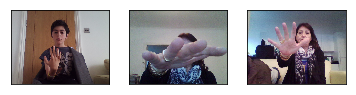

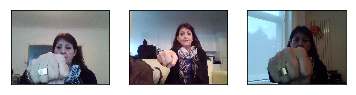

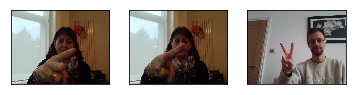

In [3]:
import matplotlib.pyplot as plt
import cv2   
n_class_elements_to_show = 3

def load_image_for_show(image_path):
    img = cv2.imread(image_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv_rgb

def plot_img_from_path(image_path, axes):
    img = load_image_for_show(image_path)
    axes.imshow(img)
    axes.set_xticks([])
    axes.set_yticks([])

train_target_int = np.array([ np.where(r==1)[0][0] for r in train_targets ])

for class_label in range(len(class_names)):
    class_indexes = np.nonzero(train_target_int==class_label)    
    f, axarr = plt.subplots(1, 3)    
    for to_show in range(n_class_elements_to_show):
        img_index = class_indexes[0][to_show]
        img_path = train_files[img_index]        
        plot_img_from_path( img_path, axarr[to_show])
plt.show()

Dataset: images re-scaling and offline augmentation

In [13]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image               
from tqdm import tqdm
import os

augmentation_factor = 10
aug_dir = 'dataset_aug'

# Resize image
def resize_image(img_path):
    #Load image
    img = cv2.imread(img_path)
        
    #Preprocess
    img = cv2.resize(img, (224,224))

# Write augmented dataset to disk
def generate_augmented():
    
    if not os.path.exists(aug_dir):
        os.makedirs(aug_dir)
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        #shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')
    for j in range(len(train_files)):#range(1):
        img_path = train_files[j]
        img =  load_img(img_path) #resize_image(img_path)
        img = img.resize((224,224)) 
        x = img_to_array(img)  
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 224, 224)
        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `preview/` directory
        out_dir = aug_dir + "/" + class_names[ train_target_int[j] ]
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        i = 0
        for batch in datagen.flow(x, batch_size=1,seed = 9, save_to_dir=out_dir, save_prefix='aug-'+str(j).zfill(3), save_format='jpeg'):
            i += 1
            if i >= augmentation_factor:
                break  # otherwise the generator would loop indefinitely

#Uncomment the next line to generate the augmented database
generate_augmented() 
print('Ok!')
 

Ok!


Now we load the augmented database and get features using ResNet50

In [7]:
from keras.applications.resnet50 import preprocess_input, ResNet50 #decode_predictions

# load train, test, and validation datasets
train_files_aug, train_targets_aug = load_dataset(aug_dir)
print('There are %d total class categories.' % len(class_names))
print('There are %d training images.' % len(train_files_aug))

# Load ResNet50
def get_ResNet50():
    model_features_Resnet50 = ResNet50( include_top=False,
                                        weights='imagenet',
                                        input_tensor=None,
                                        input_shape=None,
                                        pooling=None)
    return model_features_Resnet50


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
   
def process_ResNet50(img):
    x = image.img_to_array(img)
    img_tensor= np.expand_dims(x, axis=0)
    #Preprocess image for Resnet50
    img_preproccessed = preprocess_input(img_tensor)     
    
    #Obtain Resnet50 features    
    img_features = model_features_Resnet50.predict(img_preproccessed)
    return img_features

There are 3 total class categories.
There are 3411 training images.
